# Hyperparameter Optimization with Hyperopt



## Install Hyperopt package

In [1]:
!pip install hyperopt

     |████████████████████████████████| 1.9MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 829kB 4.1MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 4.6MB/s eta 0:00:01     |██████████████▉                 | 788kB 4.6MB/s eta 0:00:01     |███████████████████████████▋    | 1.5MB 4.6MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=493275 sha256=b3366a5e29d26982cf6022c58c48fc08f51477ce419641863d6f7fad128ff75a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for networkx: filename=networkx-2.2-py2.py3-none-any.whl size=1527657 sha256=d244b460e509d7853b7b34cab4811d10924c3f8932dacb031b414a001fd01dc7
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built future networkx
  Found existing installation: networkx 2.3
    Uninstalling networkx-2.3:
      Successfully uninstalled networ

## Import required libraries

In [2]:
import warnings
warnings.simplefilter('ignore')
from ludwig.api import LudwigModel
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.stochastic import rng_from_seed
import logging
import shutil
import tempfile

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Retrieve data for training

In [3]:
raw_df = pd.read_csv('./data/winequalityN.csv')
raw_df.shape

(6497, 13)

## Standardize column names to replace spaces(" ") with underscore("_")

In [4]:
new_col = []
for i in range(len(raw_df.columns)):
    new_col.append(raw_df.columns[i].replace(' ', '_'))
    
raw_df.columns = new_col


## Data Set Overview

In [5]:
raw_df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

## Create training and test data sets

In [6]:
train_df, vald_df = train_test_split(raw_df, test_size = 0.2, random_state=13, stratify=raw_df['quality'])
print(train_df.shape, vald_df.shape)

(5197, 13) (1300, 13)


In [7]:
train_df['quality'].value_counts().sort_index()

3      24
4     173
5    1710
6    2269
7     863
8     154
9       4
Name: quality, dtype: int64

In [8]:
vald_df['quality'].value_counts().sort_index()

3      6
4     43
5    428
6    567
7    216
8     39
9      1
Name: quality, dtype: int64

In [9]:
# isolate the predictor variables only
predictor_vars = list(set(raw_df.columns) - set(['quality']))

#extract categorical variables
categorical_vars = []
for p in predictor_vars:
    if raw_df[p].dtype == 'object':
        categorical_vars.append(p)
        
print("categorical variables:", categorical_vars,'\n')

# get numerical variables
numerical_vars = list(set(predictor_vars) - set(categorical_vars))

print("numerical variables:", numerical_vars,"\n")

categorical variables: ['type'] 

numerical variables: ['density', 'residual_sugar', 'pH', 'total_sulfur_dioxide', 'volatile_acidity', 'sulphates', 'citric_acid', 'alcohol', 'free_sulfur_dioxide', 'fixed_acidity', 'chlorides'] 



In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,5189.0,7.198824,1.282347,3.80000,6.4000,7.0000,7.7000,15.60000
volatile_acidity,5191.0,0.338963,0.165157,0.08000,0.2300,0.2900,0.4000,1.58000
citric_acid,5194.0,0.319174,0.146128,0.00000,0.2500,0.3100,0.4000,1.66000
residual_sugar,5195.0,5.424562,4.762894,0.60000,1.8000,3.0000,8.0000,65.80000
chlorides,5195.0,0.056116,0.035789,0.00900,0.0380,0.0470,0.0640,0.61100
free_sulfur_dioxide,5197.0,30.656821,17.912418,1.00000,17.0000,29.0000,42.0000,289.00000
total_sulfur_dioxide,5197.0,116.046180,56.504786,6.00000,78.0000,119.0000,156.0000,440.00000
density,5197.0,0.994672,0.003008,0.98711,0.9923,0.9948,0.9969,1.03898
pH,5189.0,3.218979,0.160672,2.72000,3.1100,3.2100,3.3200,4.01000
sulphates,5193.0,0.530924,0.147341,0.22000,0.4300,0.5100,0.6000,2.00000


In [11]:
for p in categorical_vars:
    print("unique values for",p,"is",train_df[p].nunique())

unique values for type is 2


## Create model definition

In [12]:
# template for model definition
model_definition = {'input_features':[], 'output_features': [], 'training':{}}

# setup input features for categorical variables
for p in categorical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'category', 'representation': 'sparse'}
    model_definition['input_features'].append(a_feature)


# setup input features for numerical variables
for p in numerical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    model_definition['input_features'].append(a_feature)

# set up output variable
model_definition['output_features'].append({'name': 'quality', 'type':'category'})

In [13]:
# View the model defintion
print("model definition:")
model_definition

model definition:


{'input_features': [{'name': 'type',
   'type': 'category',
   'representation': 'sparse'},
  {'name': 'density',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'residual_sugar',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'pH',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'total_sulfur_dioxide',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'volatile_acidity',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'sulphates',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'citric

## Define objective function for minimization

In [14]:
# objective for hyperopt to minimize
def score_model(params):
    
    print(params)
    
    model_definition['training']['learning_rate'] = params['learning_rate']
    model_definition['training']['batch_size'] = params['batch_size']
    model_definition['output_features'][0]['num_fc_layers'] = np.int(params['output_fc_num_layers'])
    model_definition['output_features'][0]['fc_size'] = np.int(params['output_fc_size'])
    
    model = LudwigModel(model_definition,
                        logging_level=logging.WARN)

    with tempfile.TemporaryDirectory() as tmpdirname:
        train_stats = model.train(data_train_df = train_df,
                                data_validation_df = vald_df,
                                skip_save_training_description=True, 
                                skip_save_training_statistics=True, 
                                skip_save_model=True, 
                                skip_save_progress=True,                          
                                skip_save_log=True,
                                skip_save_processed_input=True,
                                output_directory=tmpdirname,
                                random_seed=42)



    model.close()
    
    # return validation loss for last epoch as objective function value
    validation_losses = train_stats['validation']['quality']['loss']
    last_epoch = len(validation_losses)
    
    return {'loss': validation_losses[last_epoch - 1], 'status': STATUS_OK}

## Define hyperparameter search space

In [15]:
SEED=13

# function to calculate batch size
set_batch_size = lambda n: 2**(n + 5)

space = {'learning_rate':  hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01), rng=rng_from_seed(SEED)),
         'batch_size': set_batch_size(hp.randint('batch_size_exponent',3, rng=rng_from_seed(SEED))),
         'output_fc_num_layers': hp.quniform('output_fc_num_layers',1,5,1, rng=rng_from_seed(SEED)),
         'output_fc_size': hp.quniform('output_fc_size',5,200,1, rng=rng_from_seed(SEED))
        }

## Determine optimal hyperparameters

In [16]:
np.random.seed(123)
best = fmin(fn=score_model,
    space=space,
    algo=tpe.suggest,
    max_evals=30)

{'batch_size': 128, 'learning_rate': 0.002121499561203549, 'output_fc_num_layers': 5.0, 'output_fc_size': 38.0}
  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

{'batch_size': 128, 'learning_rate': 0.0001932355473302646, 'output_fc_num_layers': 1.0, 'output_fc_size': 10.0}
{'batch_size': 64, 'learning_rate': 0.0011513381010027587, 'output_fc_num_layers': 4.0, 'output_fc_size': 178.0}
{'batch_size': 128, 'learning_rate': 0.0030349889924213566, 'output_fc_num_layers': 3.0, 'output_fc_size': 47.0}
{'batch_size': 32, 'learning_rate': 0.002983993494062495, 'output_fc_num_layers': 2.0, 'output_fc_size': 93.0}
{'batch_size': 128, 'learni

In [17]:
print('batch size:', set_batch_size(best['batch_size_exponent']),
      ', learning_rate:', best['learning_rate'],
      ', fc_num_layers:', np.int(best['output_fc_num_layers']),
      ', fc_size:', np.int(best['output_fc_size']))

batch size: 128 , learning_rate: 0.00013059206203058915 , fc_num_layers: 4 , fc_size: 125


## Train with optimal hyperparameters on the whole data set

In [18]:
# clean out old results
try:
    shutil.rmtree('./results')
except:
    pass

try:
    shutil.rmtree('./visualizations')
except:
    pass



In [19]:
# set optimal hyperparameters for training    
model_definition['training']['learning_rate'] = best['learning_rate']
model_definition['training']['batch_size'] = set_batch_size(best['batch_size_exponent'])
model_definition['output_features'][0]['num_fc_layers'] = np.int(best['output_fc_num_layers'])
model_definition['output_features'][0]['fc_size'] = np.int(best['output_fc_size'])


# Define Ludwig model object that drive model training
model = LudwigModel(model_definition,
                    logging_level=logging.INFO)

# initiate model training
opt_stats = model.train(data_df = raw_df,
                        experiment_name='hyperparameter_training',
                        model_name='optimized_model',                        
                        random_seed=42)



model.close()


Experiment name: hyperparameter_training
Model name: optimized_model
Output path: results/hyperparameter_training_optimized_model


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-6a906e2e-843a-4552-a26a-71486d0f3bcc.json')
commit_hash: '8a9da7d4e494'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'type',
                              'representation': 'sparse',
                              'tied_weights': None,
                              'type': 'category'},
                          {   'name': 'density',
                              'preprocessing': {   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'residual



Using full dataframe
Building dataset (it may take a while)
Training set: 4588
Validation set: 612
Test set: 1297

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Took 0.6718s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 1.5322 │     0.4370 │      0.8520 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 1.4503 │     0.4673 │      0.8480 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 1.5337 │     0.4379 │      0.8597 │
╘═══════════╧════════╧════════════╧═════════════╛
Validation loss on combined improved, model saved


Epoch   2
Took 0.3488s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 1.2979 │     0.4911 │      0.9316 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 1.2184 │     0.5114 │      0.9

Validation loss on combined improved, model saved


Epoch  17
Took 0.2788s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.9642 │     0.6114 │      0.9632 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 1.0023 │     0.5719 │      0.9673 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 1.0354 │     0.5821 │      0.9653 │
╘═══════════╧════════╧════════════╧═════════════╛
Validation loss on combined improved, model saved


Epoch  18
Took 0.3112s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.9557 │     0.6162 │      0.9634 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9999 │     0.5752 │      0.9673 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 1.0311 │     0.5821 │      0.9661 │


Validation loss on combined improved, model saved


Epoch  33
Took 0.3024s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.8602 │     0.6587 │      0.9728 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9814 │     0.5948 │      0.9739 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9974 │     0.5860 │      0.9668 │
╘═══════════╧════════╧════════════╧═════════════╛
Validation loss on combined improved, model saved


Epoch  34
Took 0.2891s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.8549 │     0.6635 │      0.9732 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9803 │     0.5948 │      0.9739 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9965 │     0.5898 │      0.9668 │


Validation loss on combined improved, model saved


Epoch  49
Took 0.2913s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.7847 │     0.6975 │      0.9762 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9744 │     0.5948 │      0.9755 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9890 │     0.5975 │      0.9668 │
╘═══════════╧════════╧════════════╧═════════════╛
Validation loss on combined improved, model saved


Epoch  50
Took 0.3020s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.7804 │     0.6992 │      0.9767 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9739 │     0.5948 │      0.9739 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9886 │     0.5983 │      0.9668 │


Last improvement of loss on combined happened 1 epoch ago


Epoch  65
Took 0.3012s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.7176 │     0.7297 │      0.9813 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9727 │     0.5882 │      0.9722 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9876 │     0.6022 │      0.9684 │
╘═══════════╧════════╧════════════╧═════════════╛
Last improvement of loss on combined happened 2 epochs ago


Epoch  66
Took 0.3000s
╒═══════════╤════════╤════════════╤═════════════╕
│ quality   │   loss │   accuracy │   hits_at_k │
╞═══════════╪════════╪════════════╪═════════════╡
│ train     │ 0.7136 │     0.7319 │      0.9817 │
├───────────┼────────┼────────────┼─────────────┤
│ vali      │ 0.9727 │     0.5850 │      0.9739 │
├───────────┼────────┼────────────┼─────────────┤
│ test      │ 0.9881 │     0.6029

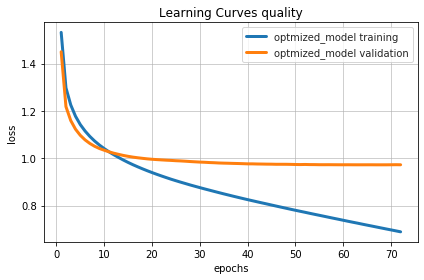

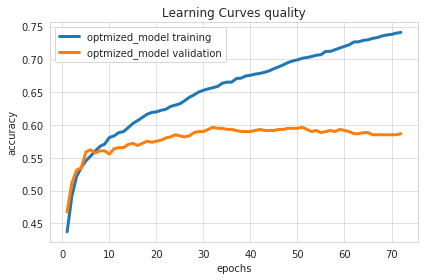

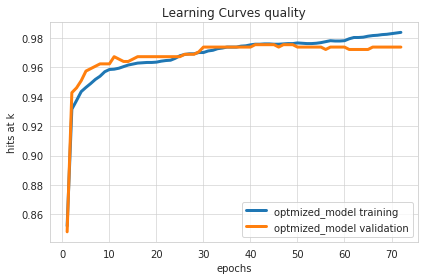

In [20]:
# generating learning curves from training
learning_curves([opt_stats], 'quality',
                model_names=['optmized_model'],
                output_directory='./visualizations',
                file_format='png')